## Part 2: Exploratory Data Analysis - TESS Dataset


[Toronto emotional speech set (TESS)](https://tspace.library.utoronto.ca/handle/1807/24487)

***Description***

These stimuli were modeled on the Northwestern University Auditory Test No. 6 (NU-6; Tillman & Carhart, 1966). A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 stimuli in total.



In [25]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#to list the files
from glob import glob


from IPython.display import Audio
import librosa

import librosa.display
from sklearn.preprocessing import scale

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_files(dir):
    
    files = glob(dir + '*/*.wav')
    print(f"{dir} file counts : ", len(files))
        
    return files

In [3]:
def play_librosa(wav_file, source='None'):
    
    print("WAV: ", wav_file)
    
    audio, sfreq = librosa.load(wav_file)
    time = np.arange(0, len(audio)) / sfreq

    print('Sample Rate:', sfreq)
    
    fig, ax = plt.subplots()
    ax.plot(time, audio)
    ax.set(xlabel='Time (sec)',  ylabel='Sound Amplitude')

    return Audio(data=audio, rate=sfreq)

In [4]:
#define hte directories/paths
tess_rootdir = './raw_source/TESS/'

In [5]:
#get the files
tess =  get_files(tess_rootdir)

./raw_source/TESS/ file counts :  2800


## Let's hear and visualiza samples 

WAV:  ./raw_source/TESS/OAF_happy/OAF_rot_happy.wav
Sample Rate: 22050


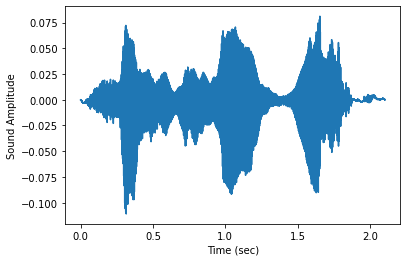

In [6]:
#testing the  WAV from TESS
play_librosa(tess[500])

## TESS 



In [7]:
#lets generate some analysis on the .wav files by getting the audio and the sample rate

tess_label = []
tess_sr = []
tess_audio = []

for t in tess:

    #get the emotion part
    tess_label.append(t.split("_")[-1].split(".")[0])
    
    #librosa output
    audio, sr = librosa.load(t)
    
    
    tess_audio.append(audio)
    tess_sr.append(sr)

In [8]:
#convert the data into dataframe

data = {'file':tess, 
        'emotion':tess_label, 
        'sr':tess_sr,
        'audio':tess_audio}
df_tess = pd.DataFrame(data)

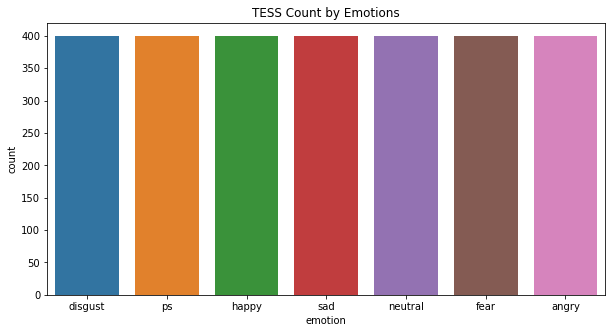

In [9]:
#distribution of the data
plt.figure(figsize=(10,5))
sns.countplot(data = df_tess, x="emotion")
plt.title("TESS Count by Emotions")
plt.savefig("./image/tess_dist.png")

*Evenly distributed except for neutral with < 100 samples*

In [10]:
#sample rate is consistent to be 22KHz
df_tess["sr"].unique()

array([22050])

In [11]:
#check the lenght of the audio file
df_tess["audio_len"] = df_tess["audio"].map(lambda x: len(x))

In [12]:
#create a time period, how many seconds per wav file
df_tess["audio_freq"] = df_tess["audio_len"] / df_tess["sr"]

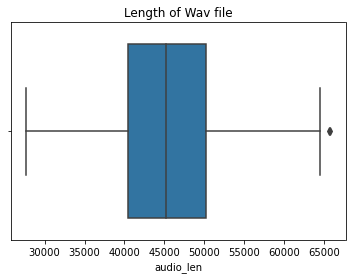

In [13]:
sns.boxplot(data = df_tess, x="audio_len")
plt.title("Length of Wav file");

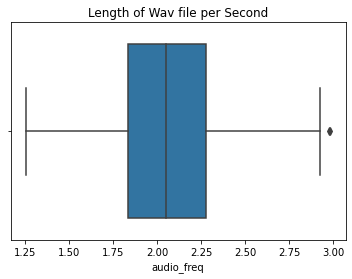

In [14]:
sns.boxplot(data = df_tess, x="audio_freq")
plt.title("Length of Wav file per Second");
plt.savefig("./image/tess_box.png")

*The average length of audio is between 1.75 to 2.25 seconds*

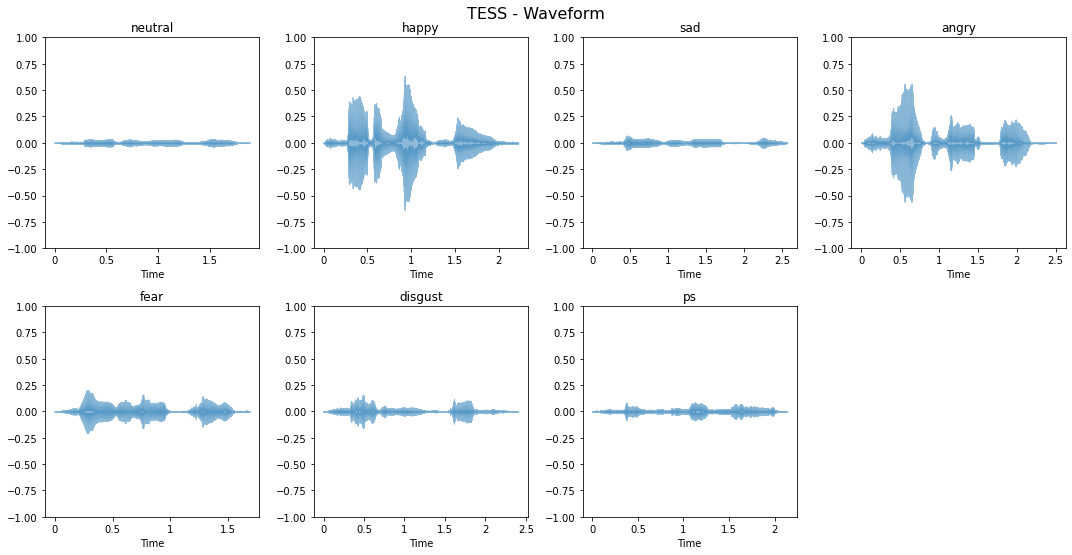

In [15]:
#let's visualize if there is difference in the audio

ls_emotion = ["neutral", "happy", "sad","angry", "fear", "disgust","ps"]
viz_normal= []

for emo in ls_emotion:
    viz_normal.append(df_tess[(df_tess["emotion"] == emo)].sample(n=1).iloc[0])

plt.figure(figsize=(15, 15))

for x in range(len(viz_normal)):
    plt.subplot(4,4,x+1)
    librosa.display.waveshow(viz_normal[x]["audio"], sr=viz_normal[x]["sr"],alpha=0.5)
    plt.title(viz_normal[x]["emotion"])
    plt.ylim((-1, 1))

plt.suptitle("TESS - Waveform", size=16);
plt.tight_layout()
plt.savefig("./image/tess_all.png")

## Calculating amplitude envelope

In [16]:
def fancy_amplitude_envelope(signal, frame_size, hop_length):
    """Fancier Python code to calculate the amplitude envelope of a signal with a given frame size."""
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_length)])
    

In [17]:
FRAME_SIZE = 512
HOP_LENGTH = 256

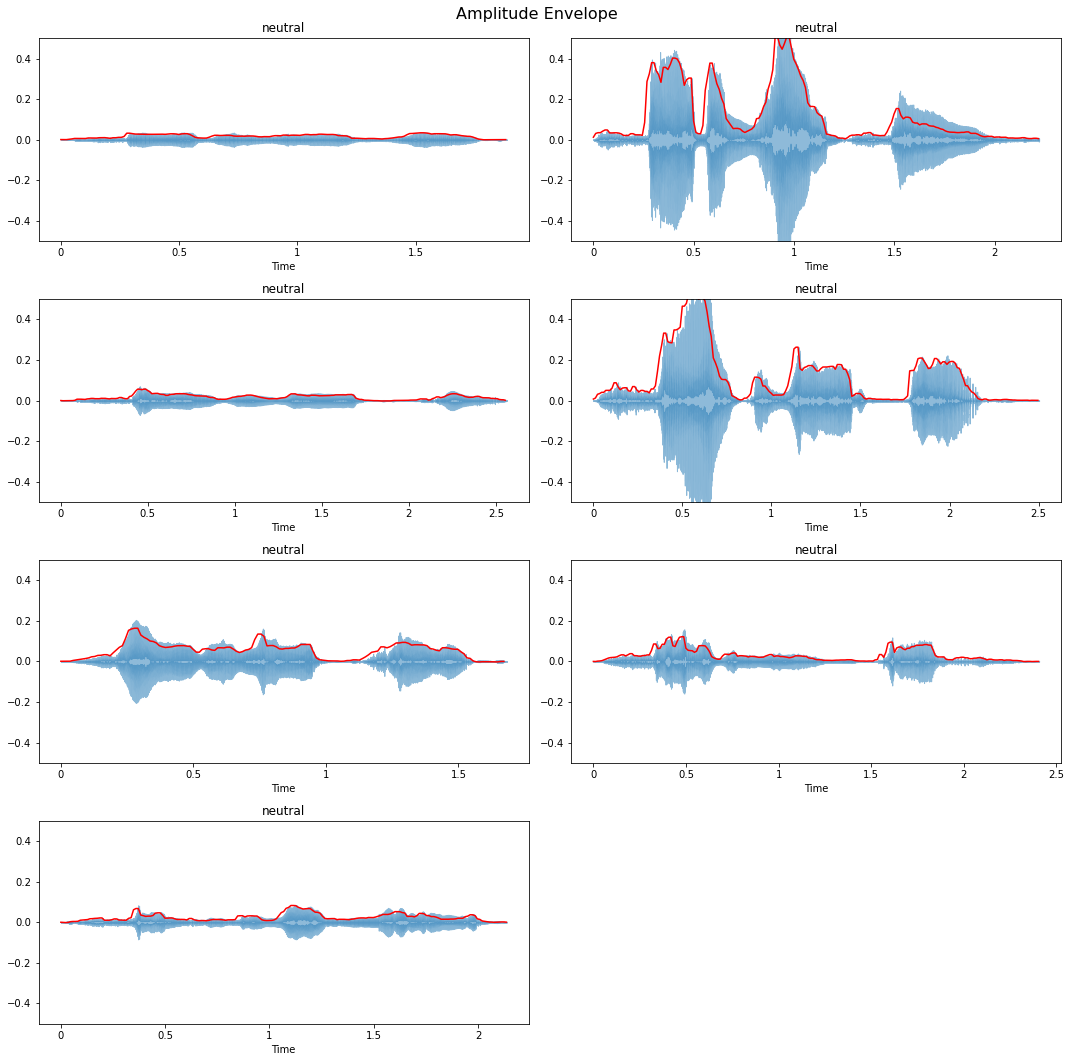

In [18]:

plt.figure(figsize=(15, 15))

for x in range(len(viz_normal)):
    plt.subplot(4,2,x+1)
    librosa.display.waveshow(viz_normal[x]["audio"], sr=viz_normal[x]["sr"],alpha=0.5)
    
    ae_normal = fancy_amplitude_envelope(viz_normal[x]["audio"], FRAME_SIZE, HOP_LENGTH)
    
    frames = range(len(ae_normal))
    t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
    plt.plot(t, ae_normal, color="r")

    plt.title(viz_normal[0]["emotion"])
    plt.ylim((-.5, .5))

plt.suptitle("Amplitude Envelope", size=16);
plt.tight_layout()


## RMSE (ROOT MEAN SQUARE ENERGY)


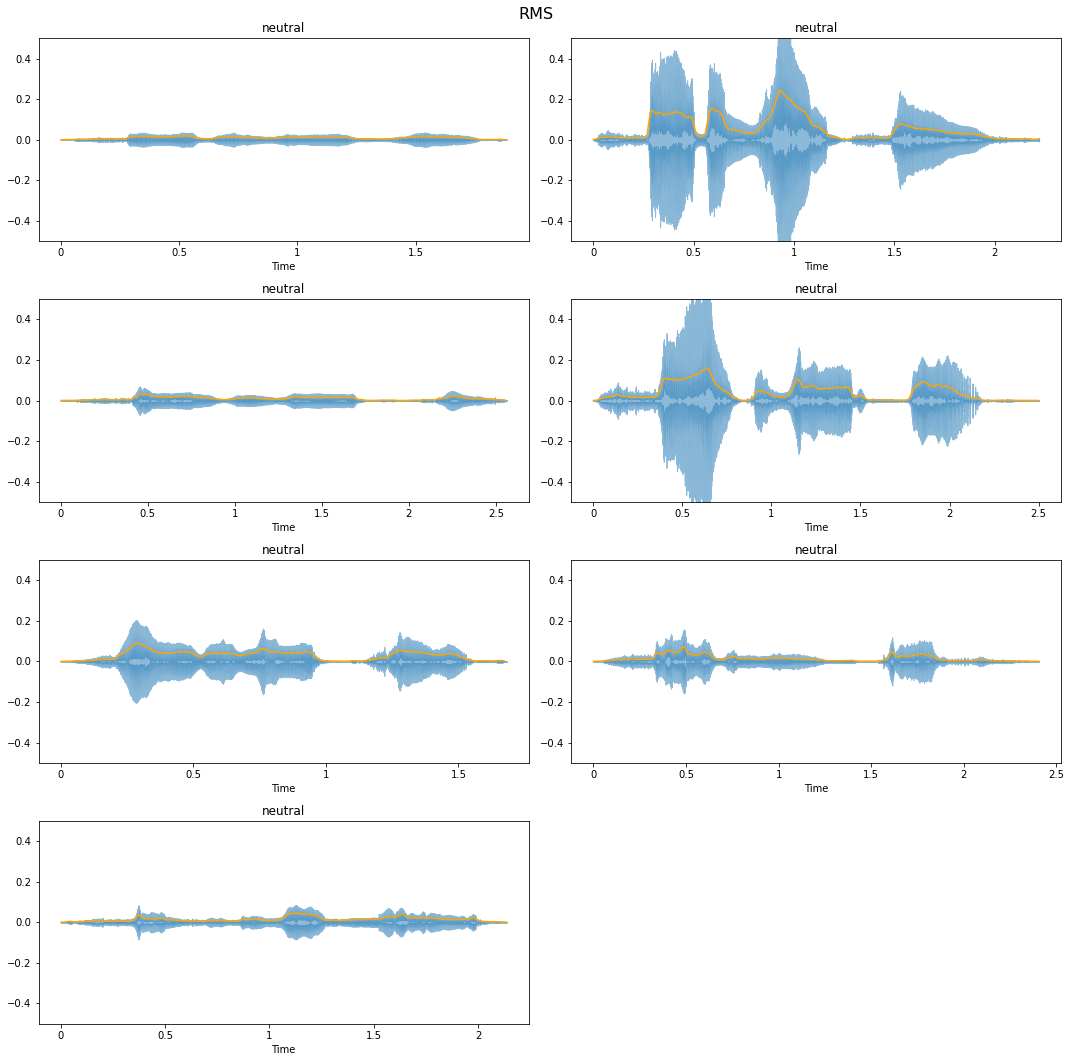

In [19]:

plt.figure(figsize=(15, 15))

for x in range(len(viz_normal)):
    plt.subplot(4,2,x+1)
    librosa.display.waveshow(viz_normal[x]["audio"], sr=viz_normal[x]["sr"],alpha=0.5)
    
    rmse = librosa.feature.rms(y=viz_normal[x]["audio"], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
    
    frames = range(len(rmse[0]))
    t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
    plt.plot(t, rmse[0], color="orange")

    plt.title(viz_normal[0]["emotion"])
    plt.ylim((-.5, .5))

plt.suptitle("RMS", size=16);
plt.tight_layout()



## ZERO CROSSING RATE

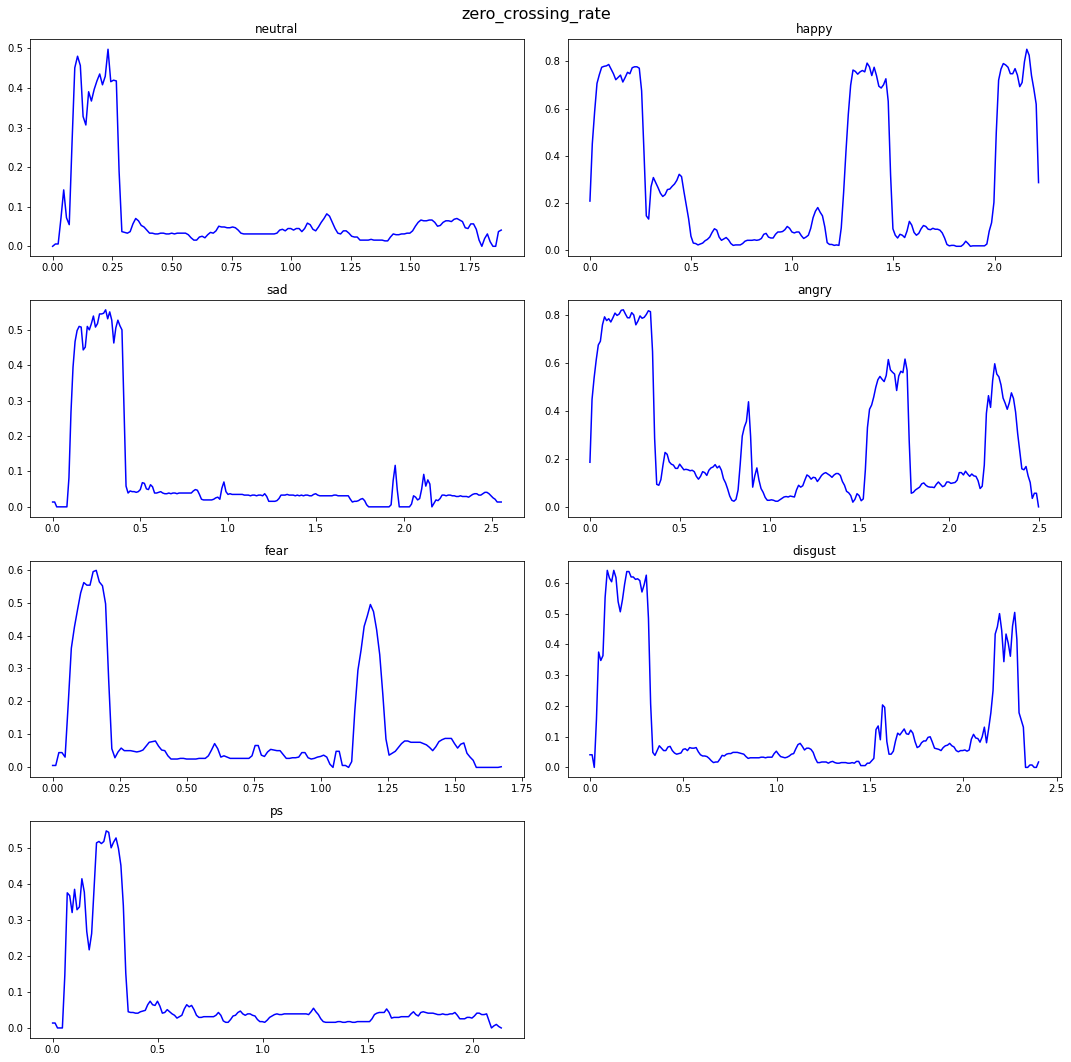

In [20]:

plt.figure(figsize=(15, 15))

for x in range(len(viz_normal)):
    plt.subplot(4,2,x+1)    
    
    crossing = librosa.feature.zero_crossing_rate(y=viz_normal[x]["audio"], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
    
    frames = range(len(crossing[0]))
    t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
    plt.plot(t, crossing[0], color="b")

    plt.title(viz_normal[x]["emotion"])

plt.suptitle("zero_crossing_rate", size=16);
plt.tight_layout()
plt.savefig("./image/tess_zero_crossing_rate.png")



# MEL Spectogram

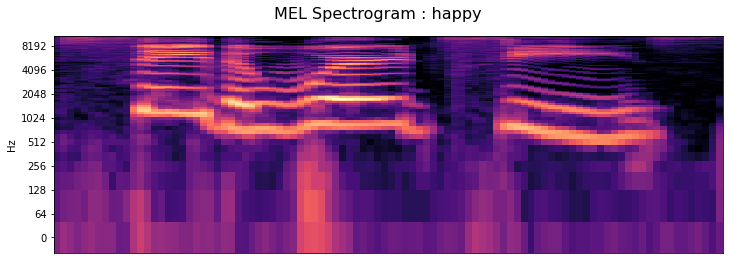

In [23]:
plt.figure(figsize=(12,4))

mel_features = librosa.feature.melspectrogram(y=viz_normal[1]["audio"], sr=viz_normal[x]["sr"])
log_mel_features = librosa.power_to_db(mel_features, ref=np.max)
img = librosa.display.specshow(log_mel_features, y_axis="log")
plt.suptitle(f"MEL Spectrogram : {viz_normal[1]['emotion']}", size=16);
          
plt.savefig("./image/tess_spectogram.png")


## Mel frequency cepstral coefficients (MFCC)


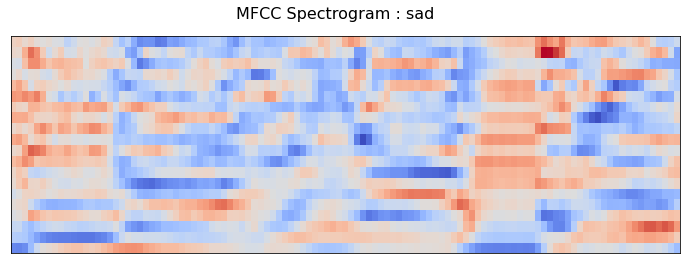

In [28]:
plt.figure(figsize=(12,4))

mfccs = librosa.feature.mfcc(y=viz_normal[2]["audio"], sr=viz_normal[x]["sr"])
mfccs = scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=viz_normal[x]["sr"])

plt.suptitle(f"MFCC Spectrogram : {viz_normal[2]['emotion']}", size=16);

plt.savefig("./image/tess_mfcc.png")

